This experiment shows that even after the pixels in hand-written digits images are scrambled, they can still be clustered effectively by t-SNE. It means that t-SNE doesn't take information about the translation/rotaional/illumination invariance in an image for clustering, which is very different from typical image recognition tasks. t-SNE itself doesn't have much to do with images, either.

In [21]:
import pandas as pd

# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [22]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

### Load data

In [23]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [24]:
print(digits['DESCR'])

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### Before scramble

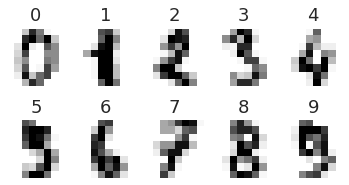

In [25]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
# plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

In [26]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [27]:
digits_proj = TSNE(random_state=RS, verbose=2).fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 8.121142
[t-SNE] Iteration 25: error = 1.7597865, gradient norm = 0.0074143
[t-SNE] Iteration 50: error = 1.5783467, gradient norm = 0.0064391
[t-SNE] Iteration 75: error = 1.1461960, gradient norm = 0.0041176
[t-SNE] Iteration 100: error = 1.0846084, gradient norm = 0.0043109
[t-SNE] Error after 100 iterations with early exaggeration: 1.084608
[t-SNE] Iteration 125: error = 0.9854247, gradient norm = 0.0038639
[t-SNE] Iteration 150: error = 0.9670529, gradient norm = 0.0044109
[t-SNE] Iteration 175: error = 0.9677989, gradient norm = 0.0038176
[t-SNE] Iteration 200: error = 0.9640027, gradient norm = 0.0039360
[t-SNE] Iteration 225: error = 0.9705969, gradient norm = 0.0046251
[t-SNE] Iteration 250: error = 0.9659890, gradient norm = 0.0048534
[t-SNE] Ite

(<matplotlib.figure.Figure at 0x7f98486df790>,
  <matplotlib.text.Text at 0x7f980415d550>])

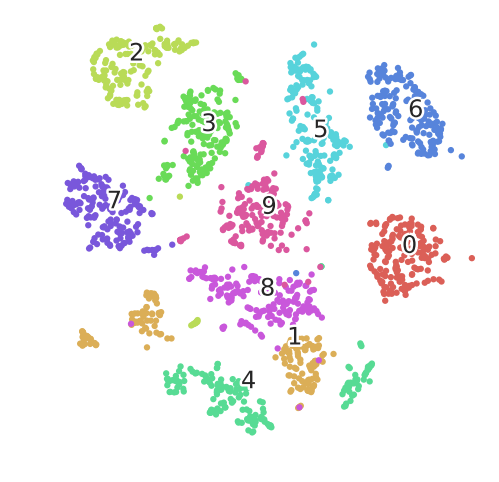

In [28]:
scatter(digits_proj, y)

### After scramble

In [29]:
digits.images.shape

(1797, 8, 8)

In [30]:
dim = digits.images.shape[1]
dim

8

In [31]:
# Generated scrambled indexes
idxes = np.random.permutation(dim ** 2).reshape((dim, dim))
idxes

array([[20,  2, 16, 30, 28, 22, 50, 51],
       [17, 52, 21, 41, 13, 56, 19, 34],
       [39, 32,  7, 10,  5, 47, 36, 63],
       [57,  4, 59, 49, 48,  0, 40, 60],
       [ 3, 23, 42, 54, 31, 27, 62, 24],
       [38, 61, 43, 58, 18, 14, 11, 12],
       [25, 46, 15, 35, 53,  6,  1, 33],
       [ 9, 45, 37,  8, 44, 26, 29, 55]])

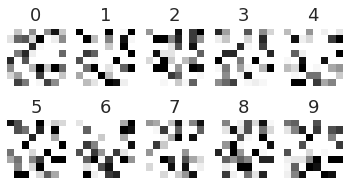

In [32]:
# Show scrambled images
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
# plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...].ravel()[idxes])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

In [33]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [34]:
df_X = pd.DataFrame(X)

In [35]:
df_X.shape

(1797, 64)

In [36]:
df_X.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


In [37]:
df_X_scrambled = df_X[df_X.columns[idxes.ravel()]]
df_X_scrambled.head(1)

,20,2,16,30,28,22,50,51,17,52,...,1,33,9,45,37,8,44,26,29,55
0,0.0,5.0,0.0,8.0,0.0,8.0,14.0,5.0,3.0,10.0,...,0.0,5.0,0.0,12.0,9.0,0.0,1.0,12.0,8.0,0.0


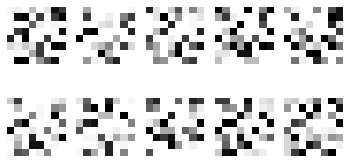

In [38]:
# Make sure columns in df_X_scrambled is indeed scrambled
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
# plt.gray()
sampled = df_X_scrambled.sample(nrows * ncols).reset_index(drop=True)
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(sampled.iloc[i].reshape(dim, dim))
    plt.xticks([]); 
    plt.yticks([])

In [39]:
digits_proj = TSNE(random_state=RS, verbose=2).fit_transform(df_X_scrambled.values)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 8.121142
[t-SNE] Iteration 25: error = 1.7601628, gradient norm = 0.0074960
[t-SNE] Iteration 50: error = 1.5779889, gradient norm = 0.0065058
[t-SNE] Iteration 75: error = 1.1458678, gradient norm = 0.0042113
[t-SNE] Iteration 100: error = 1.0841460, gradient norm = 0.0042964
[t-SNE] Error after 100 iterations with early exaggeration: 1.084146
[t-SNE] Iteration 125: error = 0.9861298, gradient norm = 0.0041633
[t-SNE] Iteration 150: error = 0.9696192, gradient norm = 0.0037047
[t-SNE] Iteration 175: error = 0.9616197, gradient norm = 0.0039074
[t-SNE] Iteration 200: error = 0.9655997, gradient norm = 0.0043739
[t-SNE] Iteration 225: error = 0.9687797, gradient norm = 0.0047719
[t-SNE] Iteration 225: did not make any progress during the last 30 episodes. F

(<matplotlib.figure.Figure at 0x7f9804685690>,
  <matplotlib.text.Text at 0x7f9802685b10>])

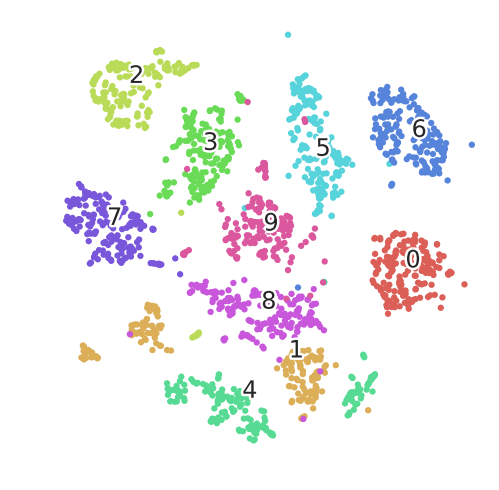

In [40]:
scatter(digits_proj, y)

You can see that even after being scrambled, the dataset can still be clustered in exactly the same way (with the same random seed) by t-SNE